# Image Segmentation - Scene Understanding


# HW3 - Segmentation

### Come up with Story

    0. You will work in groups of three. Come up with a team name.

    1. You are given powerful segmentation model, that simulates human annotator labelling the listed classes below

    2. Come up with the interesting (specific use-case) segmentation application on the images you can produce with your phone or gather from internet

    3. State in which situation it can be used, i.e. robot navigating through terrain, catching escaped animals from zoo, safari, collecting food from table etc.

    4. It can be related to your thesis as well

### Design Model

    1. You are given MobileNetV3 as a segmentation architecture. You can use whichever you want, this is just recommended as it is running realtime on gpu and can be tested on cpu

    2. You will train the model (you can use pretrained weights on different scenes) on your collected image data

    3. Split the data to training part and testing part and validate your model on testing part in terms of IoU from Teacher and visualized outputs

    4. Specify some unique scenarios for testing and show loss values and final segmentation on these cases
        - Discuss how it fails or succeded
        - Try to explain why and what you help to improve the performance on these cases

### Things that can help you

    - Strong Regularization
        1. Weight decay in torch optimizer
        2. Data augmentation
        3. Using pretrained model
        4. More training data from unique scenarios
        5. (Advanced) self-supervised pre-training

    - Server GPUs
        1. Taylor and Cantor - ssh username@taylor.felk.cvut.cz or ssh username@cantor.felk.cvut.cz
        2. Video Tutorial in server.mp4
        3. Text guide on: https://cyber.felk.cvut.cz/cs/study/gpu-servers/

### Final Presentation

    1. Describe Idea in sheets: https://docs.google.com/spreadsheets/d/1rvsg9ZgzmXiVJsiJvnpsy-yQ7N5WqADn10NL235eC1M/edit?usp=sharing

    2. Evaluation will be given on the day of presentations - 17./18.12. based on your parralel

### Evaluation

    1. Idea and preparation of data (Unique scenarios, Useful Teacher outputs, amount of training samples)

    2. Training - loss minimization, Validity of approach, Tweaks to training (Regularizations, Augmentation, ...)

    3. Examples and output overview and discussion

    4. Discussion of training times and speed of teacher and inference model. Is it sufficiently fast for the application?

    5. Presentation clarity and enthusiasm


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import tqdm
from pathlib import Path
try:
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "Apple Roboto"
except:
    pass

In [2]:
dataset = "fsoco_segmentation_processed"
dataset_dir = Path(dataset)
imgs_dir = dataset_dir / "img"
masks_dir = dataset_dir / "ann"

In [3]:
processed_imgs = list(imgs_dir.glob("*.jpeg"))
processed_masks = list(masks_dir.glob("*.npz"))
processed_imgs.sort()
processed_masks.sort()
img_mask_pairs = list(zip(processed_imgs, processed_masks))
img_mask_pairs[:5]

[(PosixPath('fsoco_segmentation_processed/img/BME_00006.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00006.npz')),
 (PosixPath('fsoco_segmentation_processed/img/BME_00019.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00019.npz')),
 (PosixPath('fsoco_segmentation_processed/img/BME_00028.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00028.npz')),
 (PosixPath('fsoco_segmentation_processed/img/BME_00039.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00039.npz')),
 (PosixPath('fsoco_segmentation_processed/img/BME_00043.jpeg'),
  PosixPath('fsoco_segmentation_processed/ann/BME_00043.npz'))]

# Dataset class and augmentations


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Class IDs to colors
classid_to_color = {
    0: (20, 20, 20),
    1: (252, 132, 3),
    2: (231, 252, 3),
    3: (255, 0, 0),
    4: (3, 40, 252),
    5: (0, 255, 0),
}


class ConeSegmentationDataset(Dataset):
    def __init__(self, img_mask_pairs, transform=None):
        self.img_mask_pairs = img_mask_pairs
        self.transform = transform

    def __len__(self):
        return len(self.img_mask_pairs)

    def __getitem__(self, idx):
        # Load the data
        img_path, mask_path = self.img_mask_pairs[idx]
        img = np.asarray(Image.open(img_path))
        # Convert image into a normalized tensor with batch dim
        img_tensor = torch.tensor(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        mask = np.load(mask_path)["arr_0"]
        # Convert 2D mask to N-classes x 2D mask in one hot sense
        one_hot_mask = nn.functional.one_hot(
            torch.from_numpy(mask).long(), num_classes=6)
        one_hot_mask = one_hot_mask.permute(2, 0, 1)
        # Apply transforms
        if self.transform:
            img_tensor, one_hot_mask = self.transform(
                (img_tensor, one_hot_mask))
        return img_tensor.float(), one_hot_mask.float()


class Normalize(object):

    def __init__(self):
        pass

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        img_tensor, mask_tensor = tup
        return (img_tensor - 127.5) / 127.5, mask_tensor


class BaseTransform(object):
    IMG_CHANNELS = 3

    def concat(self, img_tensor, mask_tensor):
        return torch.cat([img_tensor, mask_tensor], dim=0)

    def split(self, img_mask_tensor):
        img_tensor = img_mask_tensor[:self.IMG_CHANNELS]
        mask_tensor = img_mask_tensor[self.IMG_CHANNELS:]
        return img_tensor, mask_tensor


class ResizeWithMask(BaseTransform):

    def __init__(self, **kwargs):
        self.resize = transforms.Resize(**kwargs)

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be resized.
        Returns:
            Tensor: Resized image.
        """
        img_tensor, mask_tensor = tup
        # Concatenate image and mask
        img_mask_tensor = self.concat(img_tensor, mask_tensor)
        # Apply resize
        img_mask_tensor = self.resize(img_mask_tensor)
        # Split image and mask
        img_tensor, mask_tensor = self.split(img_mask_tensor)
        return img_tensor, mask_tensor


class RandomCropWithMask(BaseTransform):

    def __init__(self, **kwargs):
        self.crop = transforms.RandomCrop(**kwargs)

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be cropped.
        Returns:
            Tensor: Cropped image.
        """
        img_tensor, mask_tensor = tup
        # Concatenate image and mask
        img_mask_tensor = self.concat(img_tensor, mask_tensor)
        # Apply crop
        img_mask_tensor = self.crop(img_mask_tensor)
        # Split image and mask
        img_tensor, mask_tensor = self.split(img_mask_tensor)
        return img_tensor, mask_tensor


class RandomRotationWithMask(BaseTransform):
    def __init__(self, **kwargs):
        self.rotate = transforms.RandomRotation(**kwargs)

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be rotated.
        Returns:
            Tensor: Rotated image.
        """
        img_tensor, mask_tensor = tup
        # Concatenate image and mask
        img_mask_tensor = self.concat(img_tensor, mask_tensor)
        # Apply rotation
        img_mask_tensor = self.rotate(img_mask_tensor)
        # Split image and mask
        img_tensor, mask_tensor = self.split(img_mask_tensor)
        return img_tensor, mask_tensor


class ClasswiseColorJitter(BaseTransform):

    """
    Applies color jitter to each class segmentation mask separately
    by the given parameters.
    """

    def __init__(self, class_transform_params: dict):
        assert all([k in classid_to_color.keys()
                   for k in class_transform_params.keys()])
        self.class_transforms = {
            k:  transforms.ColorJitter(**v) for k, v in class_transform_params.items()
        }

    def __call__(self, tup):
        img_tensor, mask_tensor = tup
        for class_id, color_jitter in self.class_transforms.items():
            # Get the mask for this class
            class_mask = mask_tensor[class_id].bool()
            # Apply color jitter
            img_tensor[:, class_mask] = color_jitter(
                img_tensor[:, class_mask])
        return img_tensor, mask_tensor


class RandomHorizontalFlipWithMask(BaseTransform):
    def __init__(self, p=0.5):
        self.flip = transforms.RandomHorizontalFlip(p=p)

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be flipped.
        Returns:
            Tensor: Flipped image.
        """
        img_tensor, mask_tensor = tup
        # Concatenate image and mask
        img_mask_tensor = self.concat(img_tensor, mask_tensor)
        # Apply flip
        img_mask_tensor = self.flip(img_mask_tensor)
        # Split image and mask
        img_tensor, mask_tensor = self.split(img_mask_tensor)
        return img_tensor, mask_tensor


class RandomAffineWithMask(BaseTransform):
    def __init__(self, **kwargs):
        self.affine = transforms.RandomAffine(**kwargs)

    def __call__(self, tup):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (B,C, H, W) to be flipped.
        Returns:
            Tensor: Flipped image.
        """
        img_tensor, mask_tensor = tup
        # Concatenate image and mask
        img_mask_tensor = self.concat(img_tensor, mask_tensor)
        # Apply flip
        img_mask_tensor = self.affine(img_mask_tensor)
        # Split image and mask
        img_tensor, mask_tensor = self.split(img_mask_tensor)
        return img_tensor, mask_tensor

In [5]:
def visualize_from_torch(img, mask):
    img = img.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().permute(1, 2, 0).numpy()
    mask = np.argmax(mask, axis=-1)
    mask_img = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_id, color in classid_to_color.items():
        mask_img[mask == class_id] = color
    img = (img * 127.5 + 127.5).astype(np.uint8)
    fig, ax = plt.subplots(1, 2, figsize=(15, 7), dpi=200)
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")
    ax[1].imshow(mask_img)
    ax[1].set_title("Mask")
    ax[1].axis("off")
    plt.show()

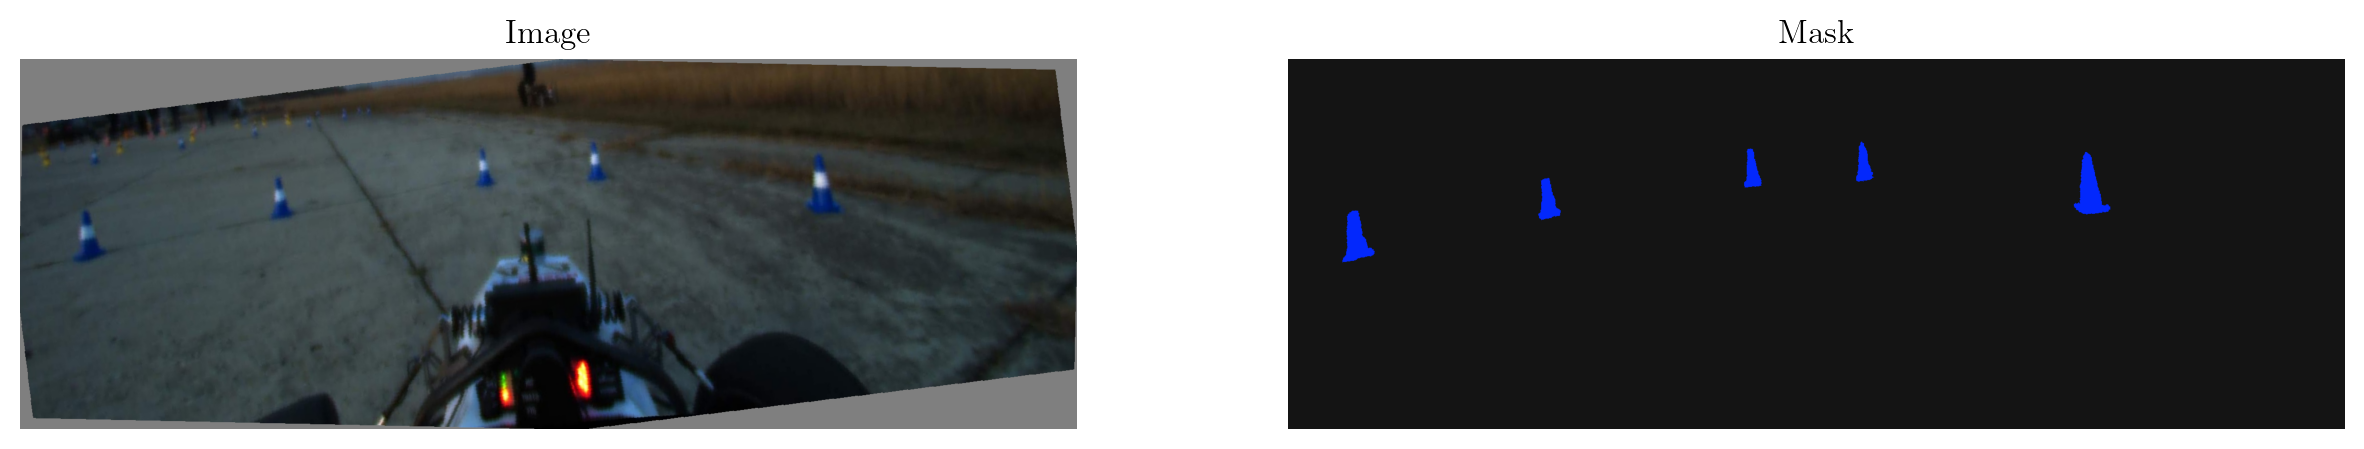

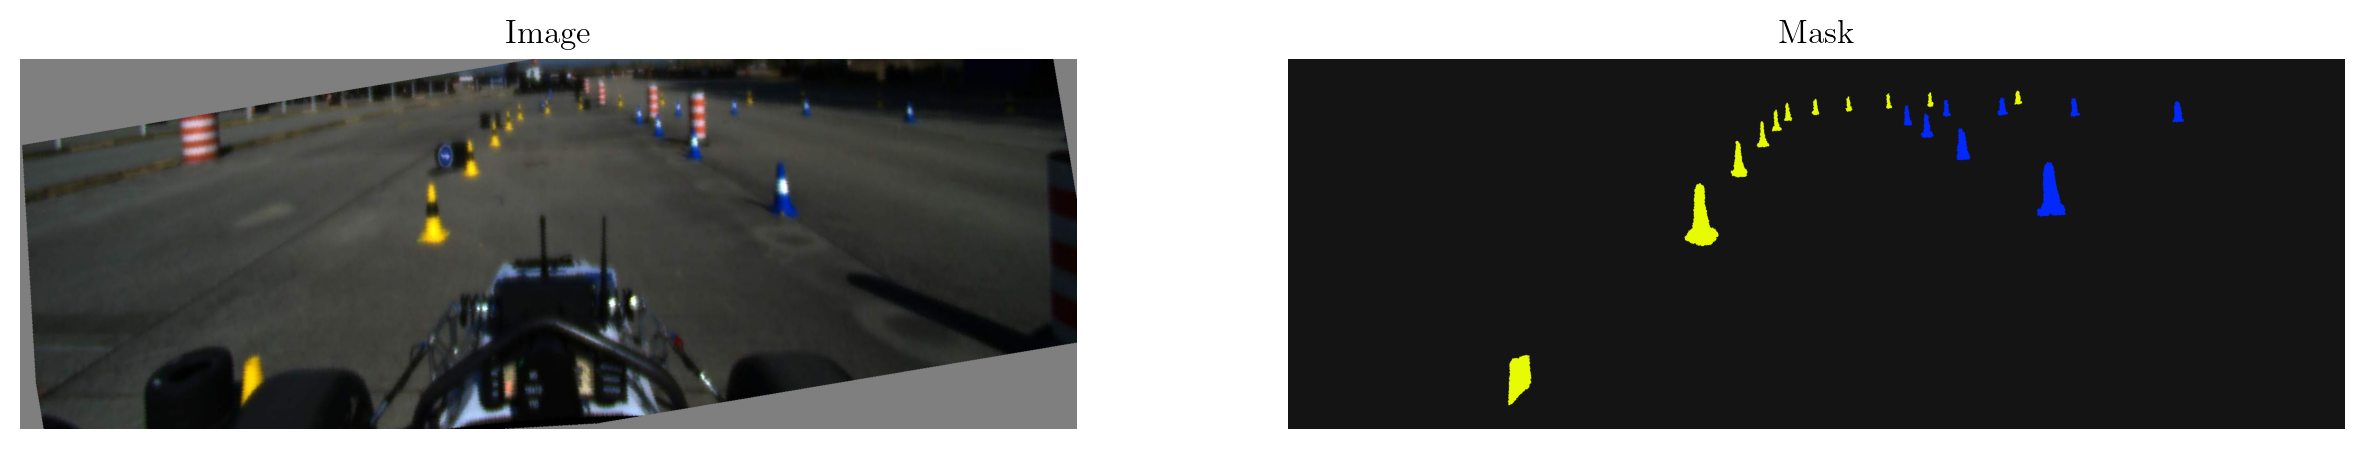

In [6]:
class_color_jitter = {
    0: {"hue": 0.5, "saturation": 0.5},
    1: {"hue": 0.5, "saturation": 0.8},
    2: {"hue": 0.5, "saturation": 0.8},
    3: {"hue": 0.5, "saturation": 0.8},
    4: {"hue": 0.5, "saturation": 0.8},
    5: {"hue": 0.5, "saturation": 0.8},
}

T = transforms.Compose(
    [
        ResizeWithMask(size=(700, 2000), antialias=True),
        Normalize(),
        RandomHorizontalFlipWithMask(0.5),
        RandomAffineWithMask(degrees=10, translate=(0.01, 0.01)),
        RandomRotationWithMask(
            degrees=10),
        ClasswiseColorJitter(class_color_jitter)
    ])

Test_T = transforms.Compose([Normalize()])

dataset = ConeSegmentationDataset(img_mask_pairs, transform=T)

for i in range(2):
    test_img, test_mask = dataset[i]
    visualize_from_torch(test_img, test_mask)

In [7]:
# Torch config
torch.manual_seed(42)
torch.multiprocessing.set_start_method('spawn')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [8]:
# Prepare dataset splits
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Transforms for training
class_color_jitter = {
    0: {"hue": 0.5, "saturation": 0.5},
    1: {"hue": 0.5, "saturation": 0.8},
    2: {"hue": 0.5, "saturation": 0.8},
    3: {"hue": 0.5, "saturation": 0.8},
    4: {"hue": 0.5, "saturation": 0.8},
    5: {"hue": 0.5, "saturation": 0.8},
}

T = transforms.Compose(
    [
        ResizeWithMask(size=(480, 640), antialias=True),
        Normalize(),
        RandomHorizontalFlipWithMask(0.5),
        RandomAffineWithMask(degrees=10, translate=(0.01, 0.01)),
        RandomRotationWithMask(
            degrees=5),
        ClasswiseColorJitter(class_color_jitter)
    ])

#  Split img-mask pairs
train_size = int(TRAIN_SIZE * len(img_mask_pairs))
val_size = int(VAL_SIZE * len(img_mask_pairs))
test_size = len(img_mask_pairs) - train_size - val_size
train_pairs, val_pairs, test_pairs = torch.utils.data.random_split(
    img_mask_pairs, [train_size, val_size, test_size])

# Create datasets
train_set = ConeSegmentationDataset(train_pairs, transform=T)
val_set = ConeSegmentationDataset(val_pairs, transform=None)
test_set = ConeSegmentationDataset(test_pairs, transform=None)

# Create dataloaders
train_loader = DataLoader(train_set, batch_size=8,
                          shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

In [9]:
from fastseg import MobileV3Large, MobileV3Small
# model = MobileV3Large(num_classes=6, use_aspp=True, num_filters=128)
model = MobileV3Small(num_classes=6, use_aspp=True, num_filters=128)
model = model.to(device)
CE = torch.nn.CrossEntropyLoss(reduction="none", weight=None)

In [ ]:
# ! BIG TODO: Transforms performed on the masks will cause float values, therefore we need to mark all the nonzero values as 1.0 to keep the binary mask

In [ ]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
for e in range(100):
    loss_mean = 0
    for x, labels in tqdm.tqdm(train_loader):
        x = x.to(device)
        labels = labels.to(device)
        output = model(x)
        loss = CE(output, labels)
        loss_mean += loss.mean().item()
        loss.mean().backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {e} loss: {loss_mean / train_size}")

# Saving weights
# torch.save(model.state_dict(), 'weights/model.pth')

In [ ]:
# Loading trained model
model.load_state_dict(torch.load('weights/model.pth', map_location='cpu'))

# Setting model to eval mode
# Always test model in eval mode
model.eval()